# Libraries

In [1]:
import csv
import os
import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import

## Articles

In [2]:
articles = []

# dir = "data/energy-geothermal/"
# dir = "data/energy-hydropower/"
# dir = "data/energy-renewable/"
dir = "data/energy-solar/"
# dir = "data/energy-wind/"

files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Title

        # Set URL and filter URL (Bob Dylan's case)
        url = data[0]["url"]
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue

        # Set entities and filter by number
        entities = data[0]["story_tags"]
        if len(entities) > 100:
            continue  # Filter max
        if len(entities) <= 1:
            continue  # Filter min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            # print('name', name)
            # Remove brackets with text
            cleaned = re.sub(r"\([^()]*\)", "", name)
            name = cleaned
            name = " ".join(name.split())  # Merge multiple spaces
            name = name.lstrip()  # Remove leading whitespaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            # print('name', name)

            if name in {"World Health Organisation"}:
                continue  # Stopwords

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "):
                    name = name[3:]  # Remove prefix
                if name.endswith(" Corp"):
                    name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"):
                    name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"):
                    name = name[:-4]  # Remive postfix
                if name[0].islower():
                    continue  # Remove lowercase
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[1].isupper():
                    continue  # Remove uppercase
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            )  # Add these articles with actors only

    except:
        continue  # In case of error


articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
).drop_duplicates(
    subset=["url"]
)  # Remove articles with the same URL

print("The number of articles is " + str(articles.shape[0]))

articles.sample(1)


The number of articles is 663


,year,title,url,subjects,orgs,people
505,2021,'Solar Bond' Demand Goes Through the Roof,https://www.wsj.com/articles/solar-bond-demand...,"[stocks and bonds, housing, finances, credit]","[Solar Mosaic, Congress, BlackRock, Wood Macke...","[Bryan White, Matt Wirz, Tanguy Serra, Billy P..."


## Entities

In [3]:
entities = np.empty((0, 12), dtype=object)

years_template = {
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in articles.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:
        update(entity, "subject")

    for entity in row["orgs"]:
        update(entity, "org")

    for entity in row["people"]:
        update(entity, "person")

# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


The total number of entities is 5083


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
2,energy and power,subject,356,NaN,None,-1,-1,-1,"{2018: 37, 2019: 37, 2020: 60, 2021: 116, 2022...",[https://www.nytimes.com/2018/02/28/opinion/so...,"[Letter: Storing Solar Energy, Europe Met a Cl...","[Hal Harvey, Ambri, electric light and power, ..."


# Treatment

## Normalization

In [4]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
382,Wood Mackenzie,org,26,NaN,None,-1,-1,-1,"{2018: 3, 2019: 3, 2020: 4, 2021: 13, 2022: 3}",[https://www.wsj.com/articles/europe-plots-sol...,[Europe Plots Solar Revival to Replace Russian...,"[Enel, Rochelle Toplensky, electric light and ...",0.070423,"{""2018"": 3, ""2019"": 3, ""2020"": 4, ""2021"": 13, ..."


## Filter

In [5]:
# Number of rows by type

# max_subjects = 1000
# max_orgs = 1000
# max_people = 1000

# top_subjects = (
#     entities_all.loc[entities_all["type"] == "subject"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_subjects)
# )
# top_orgs = (
#     entities_all.loc[entities_all["type"] == "org"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_orgs)
# )
# top_people = (
#     entities_all.loc[entities_all["type"] == "person"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_people)
# )

# entities = pd.concat([top_subjects, top_orgs, top_people])

entities = (
    entities_all[entities_all['frequency']>2]
    .sort_values(by=["frequency"], ascending=False)
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
331,Mobil,org,5,NaN,None,-1,-1,-1,"{2018: 0, 2019: 0, 2020: 1, 2021: 4, 2022: 0}",[https://www.wsj.com/articles/exxon-chevron-ti...,[Exxon-Chevron Tie-Up Not as Crazy as It Sound...,"[stocks and bonds, Rockefeller, Bloomberg News...",0.011268,"{""2018"": 0, ""2019"": 0, ""2020"": 1, ""2021"": 4, ""..."


## Linear Regression

In [6]:
# for each enetity

for i, row in entities.iterrows():

    x = list(row["years"].keys())
    x = np.array(x).reshape((-1, 1))  # needed for one-column values
    y = list(row["years"].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0] # compute linear regression
    entities.at[i, "slope"] = slope


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
995,Green Energy,org,4,0.003559,None,-1,-1,-1,"{2018: 0, 2019: 0, 2020: 1, 2021: 1, 2022: 2}",[https://www.wsj.com/articles/wind-solar-power...,"[Renewable Power Capacity Jumped in 2020, Gree...","[environment, economic conditions and trends, ...",0.008451,"{""2018"": 0, ""2019"": 0, ""2020"": 1, ""2021"": 1, ""..."


## Colors

In [7]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] != "subject":
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors
    else:
        entities.at[i, "color"] = "#cccccc"  # Subjects

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2,energy and power,subject,356,19.708081,#cccccc,-1,-1,-1,"{2018: 37, 2019: 37, 2020: 60, 2021: 116, 2022...",[https://www.nytimes.com/2018/02/28/opinion/so...,"[Letter: Storing Solar Energy, Europe Met a Cl...","[Hal Harvey, Ambri, electric light and power, ...",1.0,"{""2018"": 37, ""2019"": 37, ""2020"": 60, ""2021"": 1..."


# Embedding

## Term Frequency

In [8]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


## UMAP

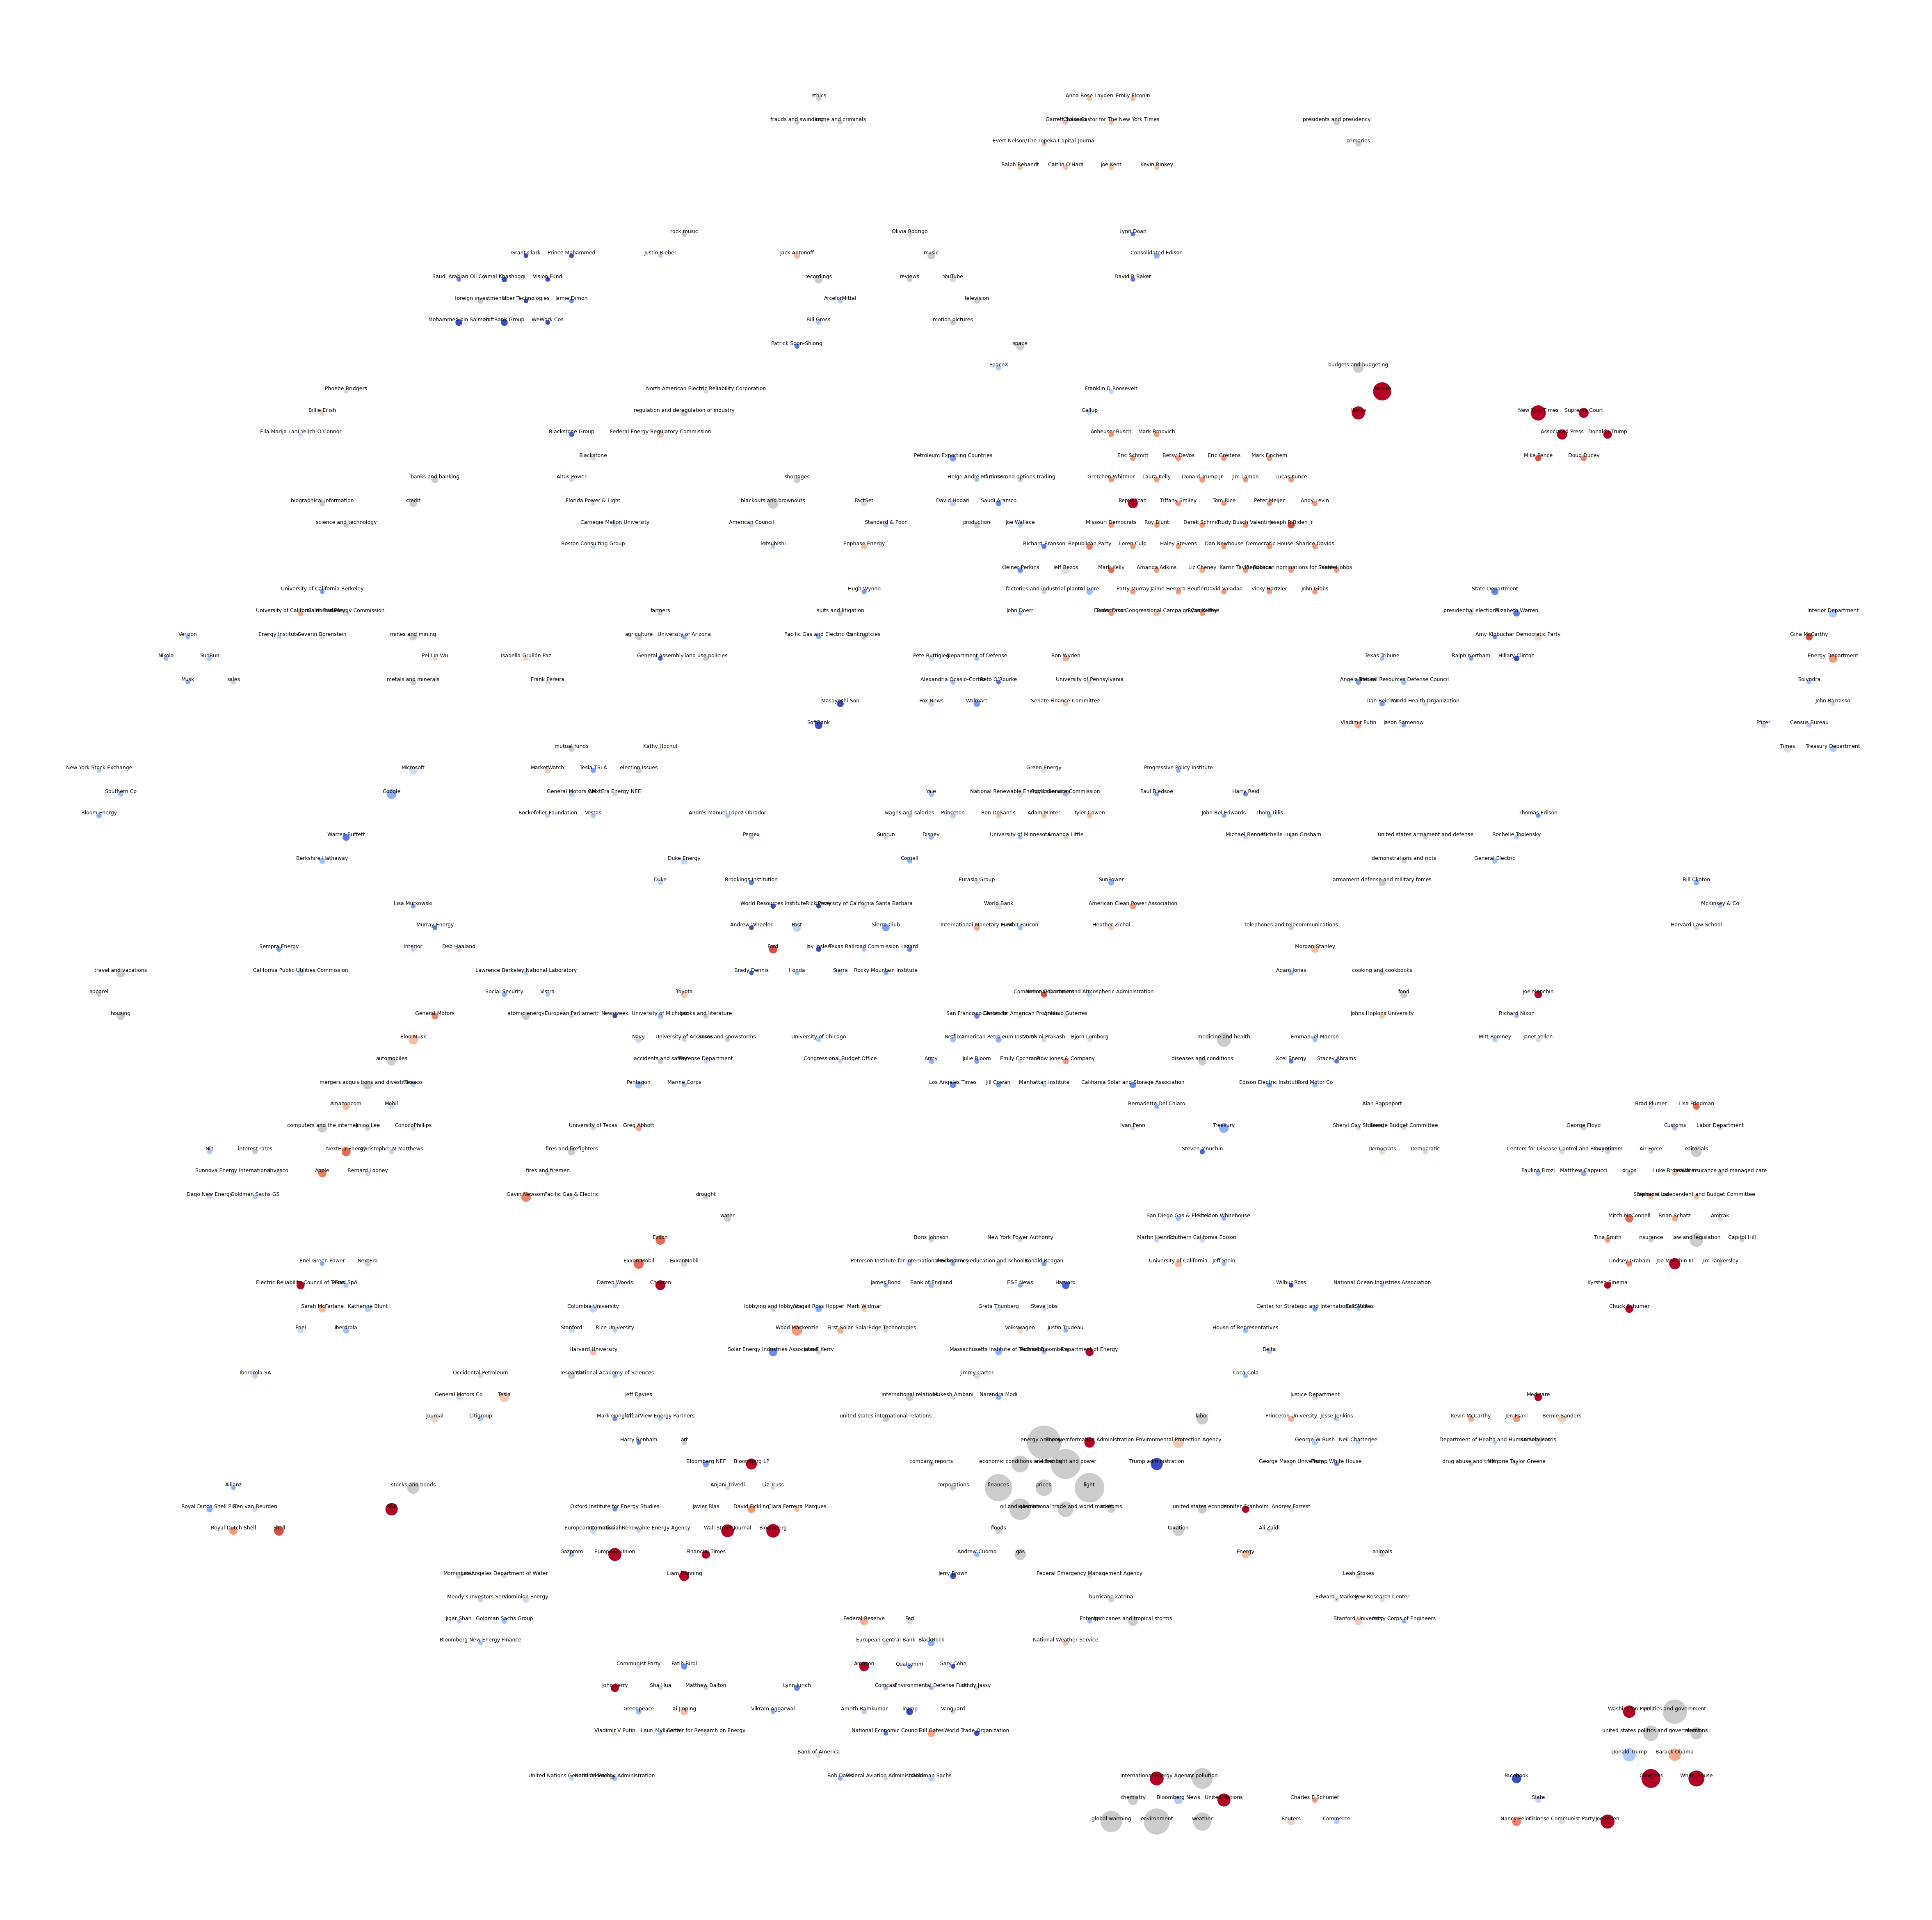

In [9]:
reducer = umap.UMAP(
    random_state=4,
    n_components=2,
    n_neighbors=2,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

{'n_13', 'p_9', 'n_12', 'n_2', 'n_8', 'p_13', 'p_4', 'n_7', 'n_9', 'p_2', 'p_11', 'n_16', '-1', 'n_6', 'n_19', 'n_3', 'n_10', 'n_20', 'n_18', 'p_14', 'p_1', 'n_4', 'p_7', 'n_5', 'p_6', 'n_1', 'n_11', 'p_3', 'n_0', 'p_12', 'n_14', 'n_17', 'p_10', 'n_15', 'p_5', 'p_8', 'p_0'}
8
7
4
13
7
11
6
20
14
5
10
17
224
13
5
10
6
13
14
5
7
5
45
10
13
6
18
6
9
5
9
6
17
6
5
9
11


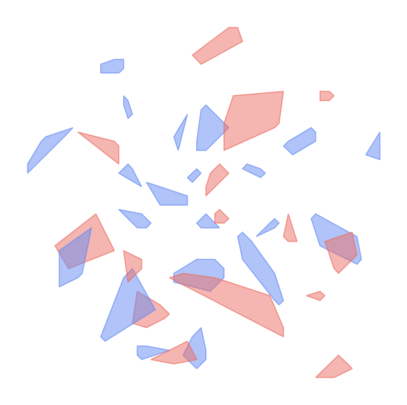

In [10]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=4,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

# entities.sample(1)

plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue



# Save

In [11]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
814,Environmental Defense Fund,org,3,-0.396441,#9fbfff,484,162,n_9,[https://www.nytimes.com/2019/07/08/climate/ne...,0.005634,"{""2018"": 0, ""2019"": 1, ""2020"": 0, ""2021"": 2, ""..."
